In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# FMCW Radar DoA Estimation

## Introduction

Direction of Arrival (DoA) estimation is a fundamental technique in radar systems used to determine the angular direction from which signals or targets originate. This capability is essential for radar surveillance, target tracking, navigation, and communication systems, enabling accurate localization and tracking of objects of interest.

DoA estimation determines the angles at which signals impinge upon an antenna array. Various algorithms exist, each with distinct advantages and trade-offs:

### Common DoA Estimation Techniques

**1. Beamforming**
Combines signals from multiple antennas to enhance signals from specific directions while suppressing interference from others. Provides basic DoA estimates based on received signal strength across the array.

**2. MUSIC (MUltiple SIgnal Classification)**
A subspace-based high-resolution algorithm that separates signal and noise subspaces. Identifies DoA through peaks in the spatial spectrum, achieving accurate localization even for closely spaced targets.

**3. Root-MUSIC**
A polynomial rooting variant of MUSIC that avoids spectral searching, providing computational efficiency while maintaining high resolution for uniform linear arrays.

**4. ESPRIT (Estimation of Signal Parameters via Rotational Invariance Techniques)**
Exploits rotational invariance in the signal subspace for efficient, high-resolution DoA estimation. Works well for both coherent and incoherent signals without requiring spectral peak searching.

**5. Capon's Method (MVDR Beamformer)**
The Minimum Variance Distortionless Response beamformer minimizes output power while maintaining unity gain in the desired direction. Offers superior performance in spatially colored noise and interference environments.

**6. Bartlett Beamformer**
A classical beamforming approach that provides baseline performance with low computational complexity. Suitable for initial DoA estimates and comparison purposes.

**7. IAA (Iterative Adaptive Approach)**
An iterative algorithm that adaptively estimates the spatial spectrum, providing high-resolution DoA estimation with improved side-lobe suppression.

### You'll Learn How To:

- Configure a MIMO FMCW radar system with virtual array synthesis
- Simulate radar returns from multiple closely-spaced targets
- Process baseband signals using range-Doppler FFT
- Extract spatial snapshots and compute covariance matrices
- Apply high-resolution DoA algorithms (MUSIC, Root-MUSIC, ESPRIT, IAA)
- Use classical beamforming techniques (Capon, Bartlett)
- Compare algorithm performance for resolving closely-spaced targets
- Visualize DoA estimation results with spatial spectra

### Application Context

This notebook demonstrates DoA estimation algorithms available in [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/)'s `processing` module. We'll apply these techniques to a simulated MIMO FMCW radar scenario with multiple closely-spaced targets, showcasing the resolution capabilities and comparative performance of each method.

## Setup a MIMO FMCW Radar

First, import the required modules from `radarsimpy` and `numpy`.


In [2]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### MIMO Array Configuration

Configure a MIMO array with **2 transmitter channels** and **64 receiver channels**, creating a synthesized **1×128 uniform linear array** with half-wavelength spacing.

**Key Configuration Details:**

- Operating frequency: 60.5 GHz (millimeter-wave)
- Transmitter spacing: Optimized for MIMO virtual array synthesis
- Receiver spacing: λ/2 for unambiguous DoA estimation
- Virtual array aperture: 128 elements

> **Note:** This example assumes orthogonal transmit waveforms (e.g., time-division multiplexing or frequency-division). The specific modulation technique is not modeled here.


In [3]:
# Calculate wavelength at 60.5 GHz operating frequency
import scipy.constants as const

wavelength = const.c / 60.5e9

# Define MIMO array dimensions
N_tx = 2  # Number of transmitters
N_rx = 64  # Number of receivers

# Configure transmitter channel positions
# Two transmitters spaced to create a 128-element virtual array
tx_channels = []
tx_channels.append(
    dict(
        location=(0, -N_rx / 2 * wavelength / 2, 0),
    )
)

tx_channels.append(
    dict(
        location=(0, wavelength * N_rx / 2 - N_rx / 2 * wavelength / 2, 0),
    )
)

# Configure receiver channel positions
# 64 receivers with λ/2 spacing (uniform linear array)
rx_channels = []
for idx in range(0, N_rx):
    rx_channels.append(
        dict(
            location=(0, wavelength / 2 * idx - (N_rx - 1) * wavelength / 4, 0),
        )
    )

### Radar System Configuration

Create the complete radar system using `RadarSimPy`'s object-oriented framework:

**Transmitter Parameters:**

- Frequencies: 60 GHz to 61 GHz
- Pulse duration: 16 μs
- Transmit power: 15 dBm
- Pulse repetition period: 40 μs
- Number of pulses: 512

**Receiver Parameters:**

- Sampling rate: 20 MHz
- Noise figure: 8 dB
- RF gain: 20 dB
- Baseband gain: 30 dB


In [4]:
# Create transmitter with FMCW waveform parameters
tx = Transmitter(
    f=[61e9, 60e9],  # Carrier frequencies (Hz)
    t=[0, 16e-6],  # Pulse timing: start and duration (s)
    tx_power=15,  # Transmit power (dBm)
    prp=40e-6,  # Pulse repetition period (s)
    pulses=512,  # Number of pulses in CPI
    channels=tx_channels,  # Transmitter array configuration
)

# Create receiver with baseband parameters
rx = Receiver(
    fs=20e6,  # ADC sampling rate (Hz)
    noise_figure=8,  # Receiver noise figure (dB)
    rf_gain=20,  # RF amplifier gain (dB)
    load_resistor=500,  # Load resistance (Ohm)
    baseband_gain=30,  # Baseband amplifier gain (dB)
    channels=rx_channels,  # Receiver array configuration
)

# Combine transmitter and receiver into radar object
radar = Radar(transmitter=tx, receiver=rx)

### Visualize Array Layout

Plot the physical positions of transmitter and receiver elements. The sparse transmitter placement combined with the dense receiver array creates a larger virtual aperture for improved angular resolution.


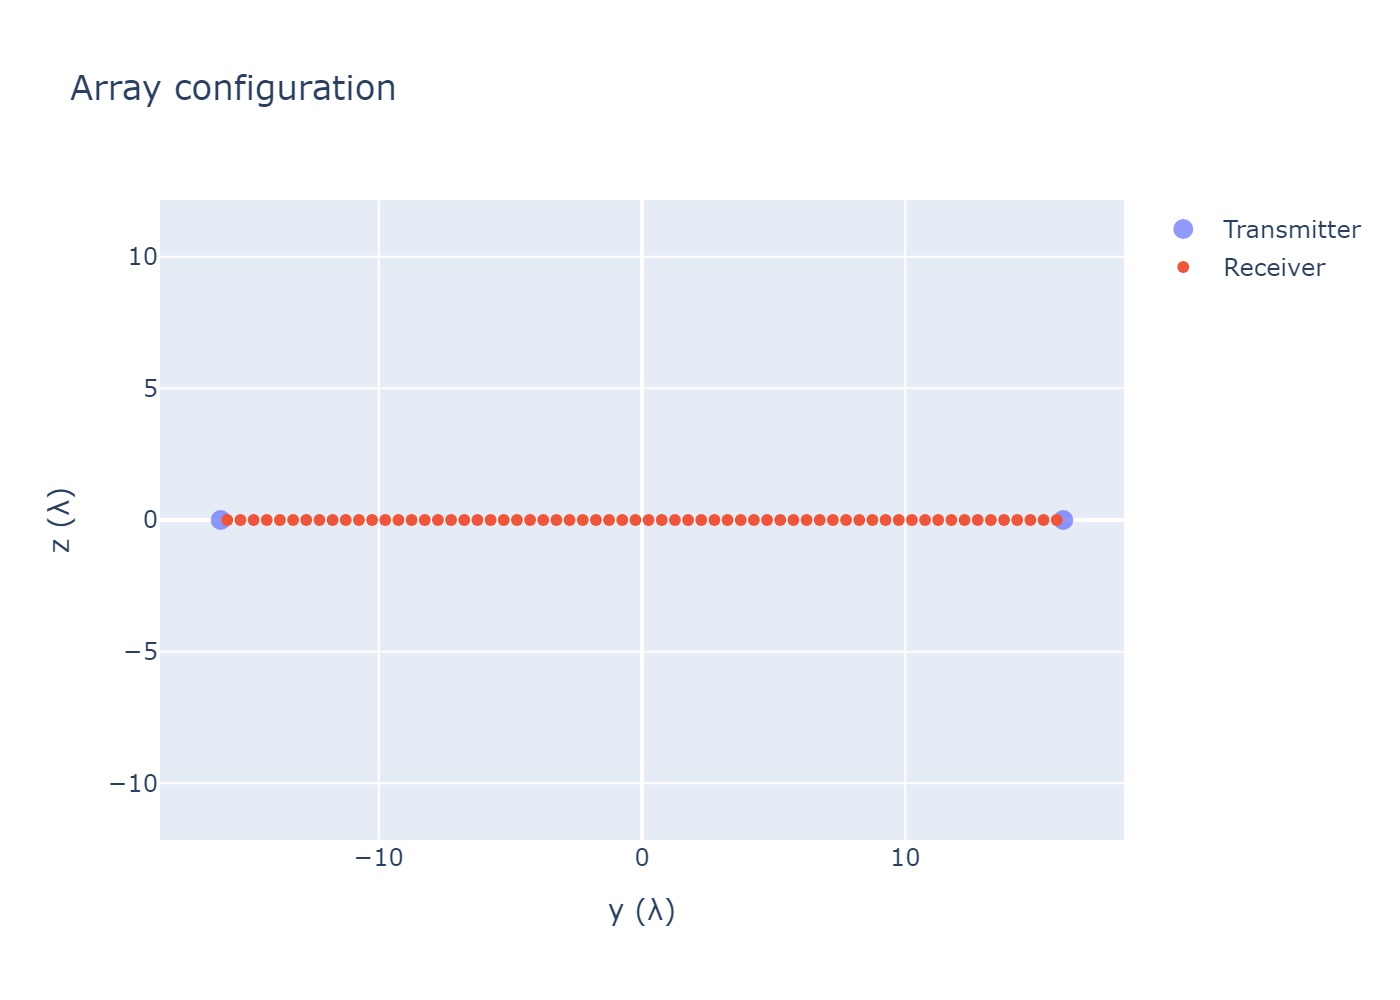

In [5]:
# Import plotting libraries
import plotly.graph_objs as go
from IPython.display import Image

# Create figure for array layout visualization
fig = go.Figure()

# Plot transmitter positions
fig.add_trace(
    go.Scatter(
        x=radar.radar_prop["transmitter"].txchannel_prop["locations"][:, 1]
        / wavelength,
        y=radar.radar_prop["transmitter"].txchannel_prop["locations"][:, 2]
        / wavelength,
        mode="markers",
        name="Transmitter",
        opacity=0.7,
        marker=dict(size=10),
    )
)

# Plot receiver positions
fig.add_trace(
    go.Scatter(
        x=radar.radar_prop["receiver"].rxchannel_prop["locations"][:, 1] / wavelength,
        y=radar.radar_prop["receiver"].rxchannel_prop["locations"][:, 2] / wavelength,
        mode="markers",
        opacity=1,
        name="Receiver",
    )
)

# Configure plot layout with normalized coordinates (in wavelengths)
fig.update_layout(
    title="Array configuration",
    xaxis=dict(title="y (λ)"),
    yaxis=dict(title="z (λ)", scaleanchor="x", scaleratio=1),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Target Scenario

Define a challenging scenario with **three targets** at 40 m range:

- **Target 1:** -5° azimuth (10 dBsm RCS)
- **Target 2:** -4° azimuth (10 dBsm RCS)
- **Target 3:** 45° azimuth (10 dBsm RCS)

The first two targets are separated by only **1°**, testing the angular resolution capabilities of different DoA algorithms. All targets are stationary (zero velocity).


In [6]:
# Define true target angles for validation
true_theta = [-5, -4, 45]  # Azimuth angles in degrees

# Target 1: -5 degrees azimuth, 40m range
target_1 = dict(
    location=(
        40 * np.cos(np.radians(true_theta[0])),  # x position
        40 * np.sin(np.radians(true_theta[0])),  # y position
        0,  # z position
    ),
    speed=(0, 0, 0),  # Stationary target
    rcs=10,  # Radar cross section (dBsm)
    phase=0,  # Initial phase (radians)
)

# Target 2: -4 degrees azimuth, 40m range (closely spaced with Target 1)
target_2 = dict(
    location=(
        40 * np.cos(np.radians(true_theta[1])),
        40 * np.sin(np.radians(true_theta[1])),
        0,
    ),
    speed=(0, 0, 0),
    rcs=10,
    phase=0,
)

# Target 3: 45 degrees azimuth, 40m range
target_3 = dict(
    location=(
        40 * np.cos(np.radians(true_theta[2])),
        40 * np.sin(np.radians(true_theta[2])),
        0,
    ),
    speed=(0, 0, 0),
    rcs=10,
    phase=0,
)

# Combine targets into list for simulation
targets = [target_1, target_2, target_3]

## Simulate Baseband Signals

Use `radarsimpy.simulator.sim_radar` to generate baseband samples from the radar and target configuration.

**Output Structure:**

- `timestamp`: Time stamps for each sample
- `baseband`: Complex baseband signals
- `noise`: System noise contribution

Data dimensions: `[channels, pulses, ADC samples]`

- Channels: 128 (2 Tx × 64 Rx virtual array)
- Pulses: 512 (slow-time dimension)
- Samples: Determined by pulse duration and sampling rate


In [7]:
# Import radar simulation module
from radarsimpy.simulator import sim_radar

# Simulate radar returns from targets
data = sim_radar(radar, targets)

# Extract timestamp and baseband signals
timestamp = data["timestamp"]  # Time stamps for each sample
baseband = data["baseband"] + data["noise"]  # Complex baseband with noise added

## Range-Doppler Processing

Apply 2D FFT processing to separate targets in range and Doppler dimensions:

**Processing Steps:**

1. **Range FFT:** Transform fast-time (ADC samples) to range bins
2. **Doppler FFT:** Transform slow-time (pulse-to-pulse) to Doppler bins

**Windowing:**

- Range: Chebyshev window with 80 dB sidelobe suppression
- Doppler: Chebyshev window with 60 dB sidelobe suppression

This produces a range-Doppler map for each virtual antenna element.


In [8]:
# Import signal processing modules
from scipy import signal
import radarsimpy.processing as proc

# Create window functions for sidelobe suppression
# Range window: 80 dB Chebyshev for range FFT
range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=80)

# Doppler window: 60 dB Chebyshev for Doppler FFT
doppler_window = signal.windows.chebwin(
    radar.radar_prop["transmitter"].waveform_prop["pulses"], at=60
)

# Perform 2D FFT: range and Doppler processing
# Output shape: [channels, Doppler bins, range bins]
range_doppler = proc.range_doppler_fft(baseband, rwin=range_window, dwin=doppler_window)

### Extract Beam Vector and Compute Covariance Matrix

**Beam Vector Extraction:**

1. Identify the peak detection in the range-Doppler map (all targets at same range/Doppler)
2. Extract the spatial snapshot across all 128 virtual array elements
3. Normalize the beam vector

**Covariance Matrix Estimation:**

- Create multiple spatial snapshots using a sliding window approach
- Use 20 snapshots for robust covariance estimation
- Compute spatial covariance: essential input for subspace-based DoA algorithms

The covariance matrix captures the spatial correlation structure needed by MUSIC, ESPRIT, and other advanced algorithms.


In [9]:
# Import linear algebra module
from scipy import linalg

# Find peak detection in range-Doppler map
# Average across all channels and find maximum range bin (targets at zero Doppler)
det_idx = [np.argmax(np.mean(np.abs(range_doppler[:, 0, :]), axis=0))]

# Extract beam vector (spatial snapshot) at detection point
bv = range_doppler[:, 0, det_idx[0]]  # All channels, zero Doppler, peak range bin

# Normalize beam vector
bv = bv / linalg.norm(bv)

# Number of snapshots for covariance matrix estimation
snapshots = 20

# Create snapshot matrix using sliding window approach
# Each column is a spatial snapshot of (N_tx*N_rx - snapshots) elements
bv_snapshot = np.zeros((N_tx * N_rx - snapshots, snapshots), dtype=complex)

for idx in range(0, snapshots):
    bv_snapshot[:, idx] = bv[idx : (idx + N_tx * N_rx - snapshots)]

# Compute spatial covariance matrix from snapshots
# This captures the spatial correlation structure needed for DoA algorithms
covmat = np.cov(bv_snapshot.conjugate())

### Baseline: FFT-Based DoA Estimation

Apply standard FFT to the beam vector for basic DoA estimation.

**Observations:**

- Two distinct peaks are visible, but the closely-spaced targets at -5° and -4° **cannot be resolved**
- This demonstrates the fundamental resolution limit of FFT-based methods
- Angular resolution is limited by the array aperture and windowing

This motivates the need for high-resolution DoA algorithms shown in subsequent cells.


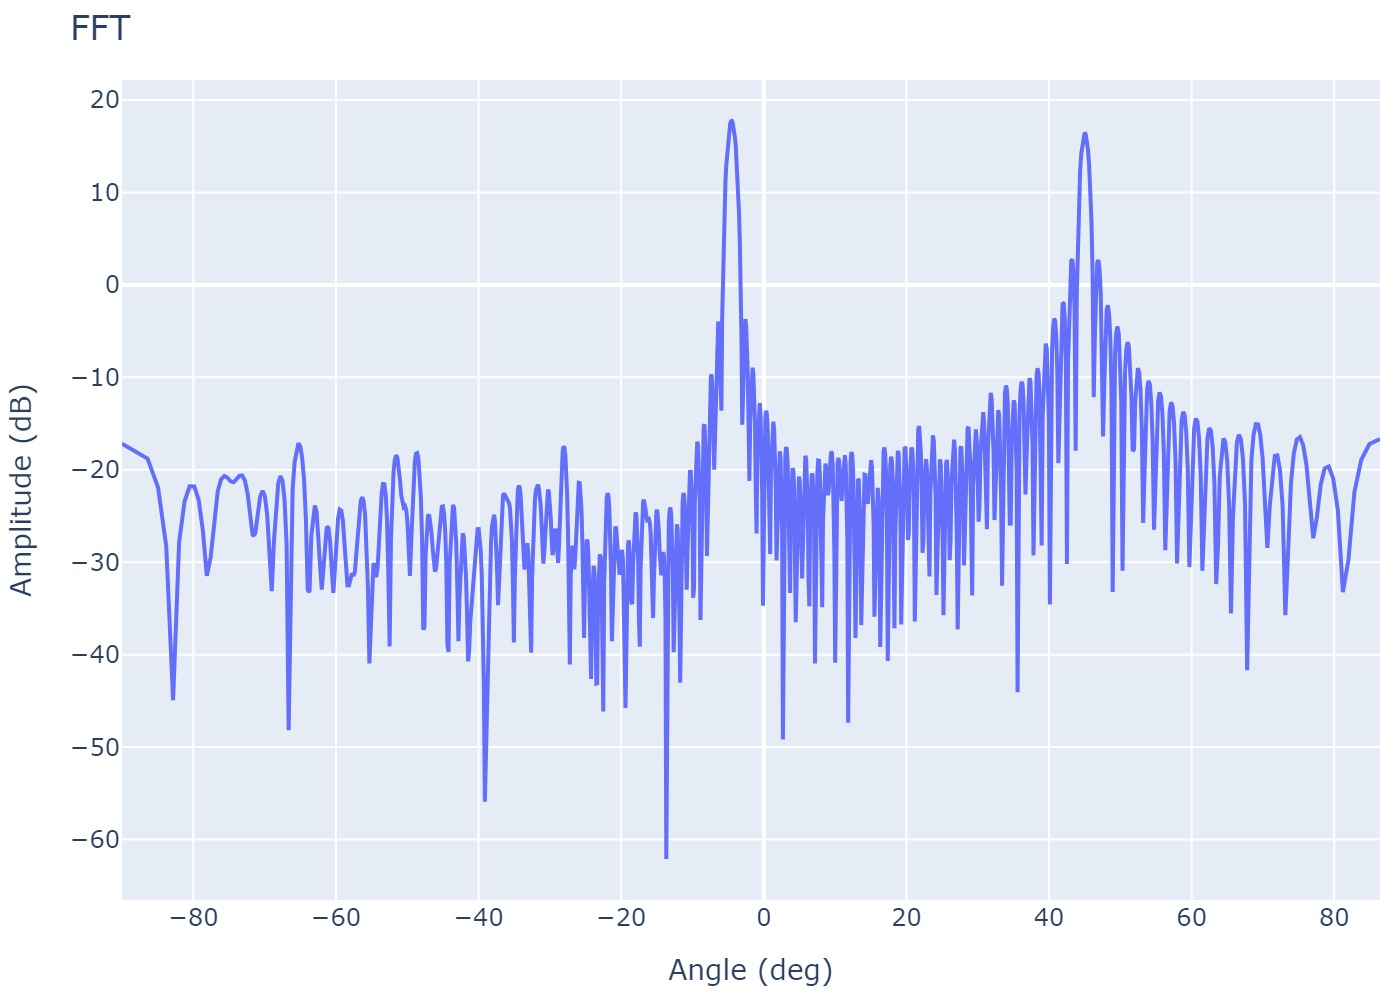

In [10]:
# Import FFT module
from scipy import fft

# Compute FFT-based angular spectrum (1024-point for fine resolution)
fft_spec = 20 * np.log10(np.abs(fft.fftshift(fft.fft(bv.conjugate(), n=1024))))

# Create figure for FFT spectrum
fig = go.Figure()

# Plot FFT spectrum vs angle
# Convert normalized frequency to angle using arcsin (u-space to angle)
fig.add_trace(
    go.Scatter(
        x=np.degrees(np.arcsin(np.linspace(-1, 1, 1024, endpoint=False))),
        y=fft_spec,
        name="FFT",
    )
)

# Configure plot layout
fig.update_layout(
    title="FFT",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## High-Resolution DoA Algorithms

The following sections demonstrate various DoA estimation algorithms, comparing their performance in resolving the closely-spaced targets.

### MUSIC (MUltiple SIgnal Classification)

MUSIC is a subspace-based algorithm that achieves super-resolution by exploiting the orthogonality between signal and noise subspaces.

**Parameters:**

- Covariance matrix: Spatial correlation of received signals
- Number of sources: 3 (known target count)
- Scan angles: -90° to 90° with 0.1° resolution

MUSIC can resolve targets separated by less than the array's Rayleigh resolution limit.


In [11]:
# Import MUSIC DoA estimation algorithm
from radarsimpy.processing import doa_music

# Define scan angles for spatial spectrum
scan_angle = np.arange(-90, 90, 0.1)  # -90° to 90° with 0.1° resolution

# Apply MUSIC algorithm
# covmat: spatial covariance matrix
# 3: number of signal sources (targets)
# scanangles: angles to search over
music_doa, music_idx, ps_db = doa_music(covmat, 3, scanangles=scan_angle)

# Display estimated DoA angles
print("DoAs from MUSIC:", music_doa, "degrees")

DoAs from MUSIC: [-5. -4. 45.] degrees


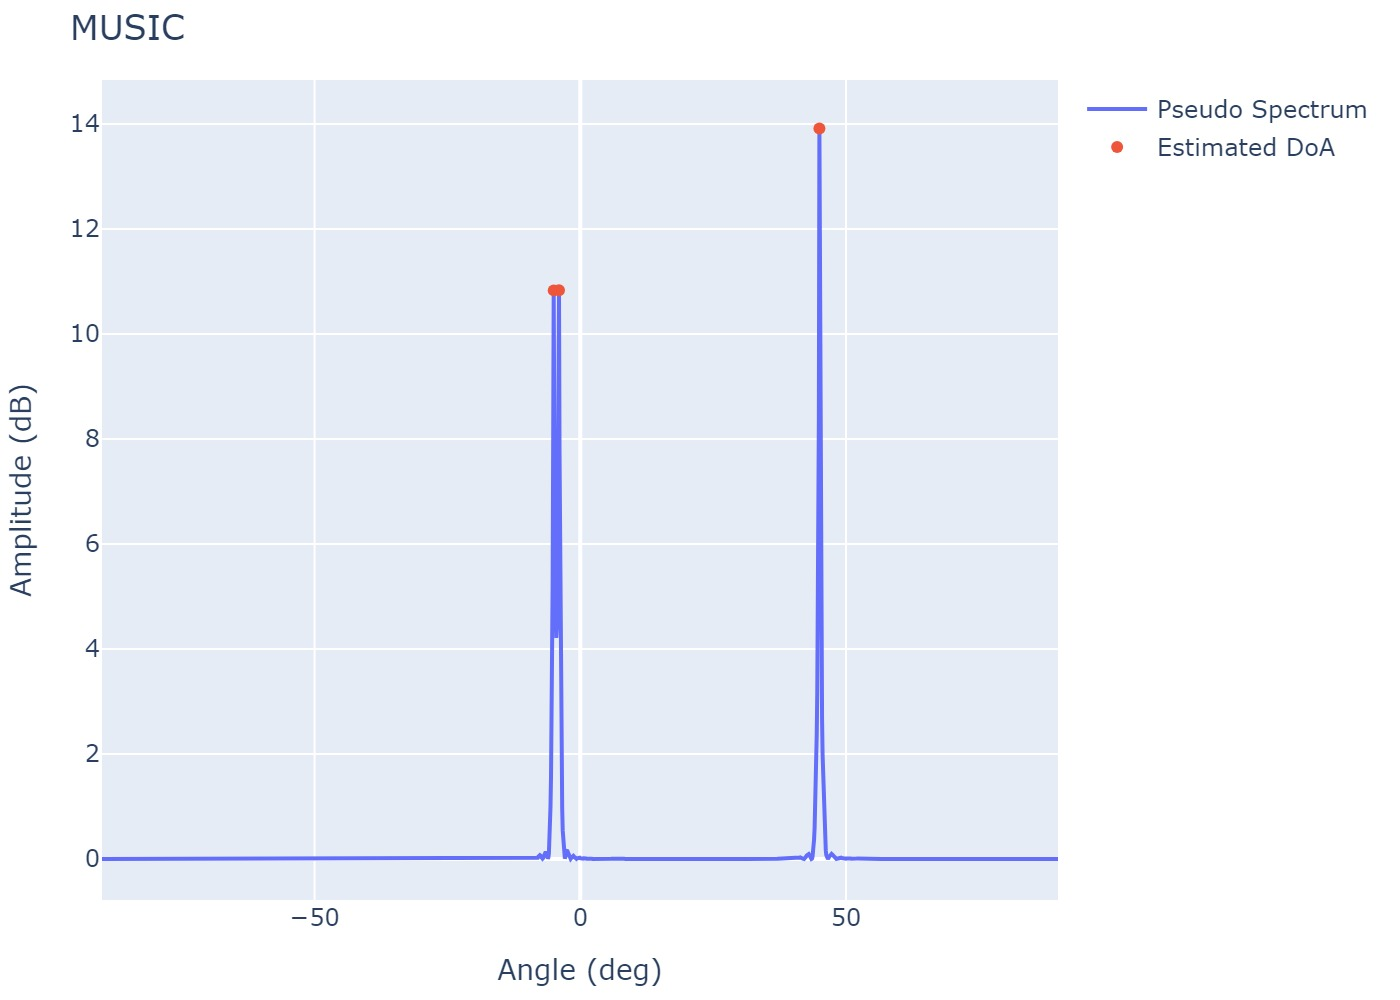

In [12]:
# Create figure for MUSIC results
fig = go.Figure()

# Plot MUSIC pseudo-spectrum
fig.add_trace(go.Scatter(x=scan_angle, y=ps_db, name="Pseudo Spectrum"))

# Mark estimated DoA peaks
fig.add_trace(
    go.Scatter(x=music_doa, y=ps_db[music_idx], mode="markers", name="Estimated DoA")
)

# Configure plot layout
fig.update_layout(
    title="MUSIC",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Root-MUSIC

Root-MUSIC reformulates the MUSIC spectral search as a polynomial rooting problem, offering:

- **Higher computational efficiency** (no spectral scanning required)
- **Automatic peak finding** through root selection
- **Equivalent accuracy** to MUSIC for uniform linear arrays

This method is particularly efficient for real-time applications where computational resources are limited.


In [13]:
# Import Root-MUSIC algorithm
from radarsimpy.processing import doa_root_music

# Apply Root-MUSIC algorithm (polynomial rooting approach)
# No spectral scanning required - directly computes DoA from roots
rootmusic_doa = doa_root_music(covmat, 3)

# Display estimated DoA angles
print("DoAs from Root-MUSIC:", rootmusic_doa, "degrees")

DoAs from Root-MUSIC: [45.01791521 -4.00479609 -4.99830258] degrees


### ESPRIT (Estimation of Signal Parameters via Rotational Invariance Techniques)

ESPRIT exploits the shift-invariance property of uniform arrays to estimate DoA without spectral searching.

**Advantages:**

- **Closed-form solution** (no iterative search)
- **Computationally efficient** compared to MUSIC
- **High accuracy** for uniform linear arrays

ESPRIT directly computes DoA from eigenvalues of a rotation operator matrix.


In [14]:
# Import ESPRIT algorithm
from radarsimpy.processing import doa_esprit

# Apply ESPRIT algorithm (rotational invariance approach)
# Closed-form solution without spectral search
esprit_doa = doa_esprit(covmat, 3)

# Display estimated DoA angles
print("DoAs from ESPRIT:", esprit_doa, "degrees")

DoAs from ESPRIT: [45.01884533 -4.01731373 -5.01857199] degrees


### IAA (Iterative Adaptive Approach)

IAA is an iterative algorithm that adaptively estimates the power spectrum with improved resolution and side-lobe suppression.

**Process:**

1. Construct steering vectors for all scan angles
2. Iteratively refine power estimates
3. Converge to high-resolution spatial spectrum

**Benefits:**

- Excellent side-lobe suppression
- No requirement for source number estimation
- Works well with correlated sources


In [15]:
# Import IAA algorithm
from radarsimpy.processing import doa_iaa

# Define azimuth scan angles
azimuth = np.arange(-90, 90, 0.1)  # Degrees

# Get virtual array element positions (normalized by wavelength)
array_loc = radar.array_prop["virtual_array"][:, 1] / wavelength

# Construct steering vector matrix for all scan angles
# Each column represents the array response for a specific angle
# Vectorized calculation: (N_elements, N_angles)
steering_vect = np.exp(
    -1j * 2 * np.pi * array_loc[:, np.newaxis] * np.sin(np.radians(azimuth))
)

# Apply IAA algorithm with beam vector and steering vectors
spec_iaa = doa_iaa(bv, steering_vect)

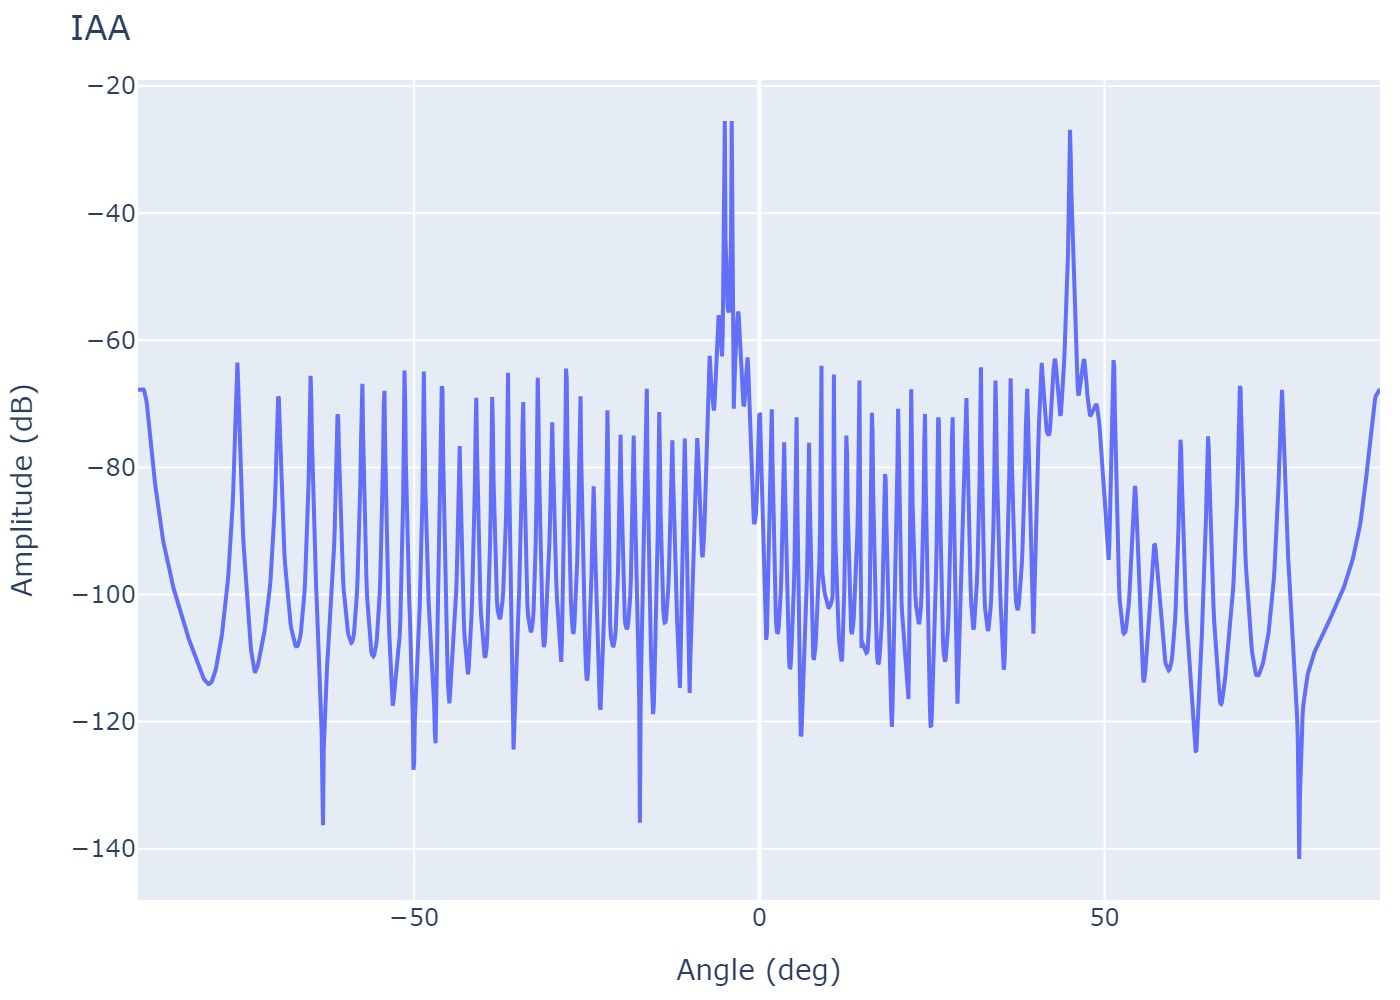

In [16]:
# Create figure for IAA results
fig = go.Figure()

# Plot IAA pseudo-spectrum
fig.add_trace(go.Scatter(x=azimuth, y=spec_iaa, name="Pseudo Spectrum"))

# Configure plot layout
fig.update_layout(
    title="IAA",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Classical Beamforming Methods

### Capon Beamformer (MVDR)

The Minimum Variance Distortionless Response (MVDR) beamformer, also known as Capon's method:

**Principle:**

- Minimize output power (interference and noise)
- Maintain unity gain in the desired direction
- Adaptive nulling of interference

**Characteristics:**

- Better resolution than Bartlett beamforming
- Improved interference rejection
- Moderate computational complexity


In [17]:
# Import Capon beamformer
from radarsimpy.processing import doa_capon

# Apply Capon (MVDR) beamformer
# Adaptive beamforming with interference suppression
ps_capon = doa_capon(covmat, scanangles=scan_angle)

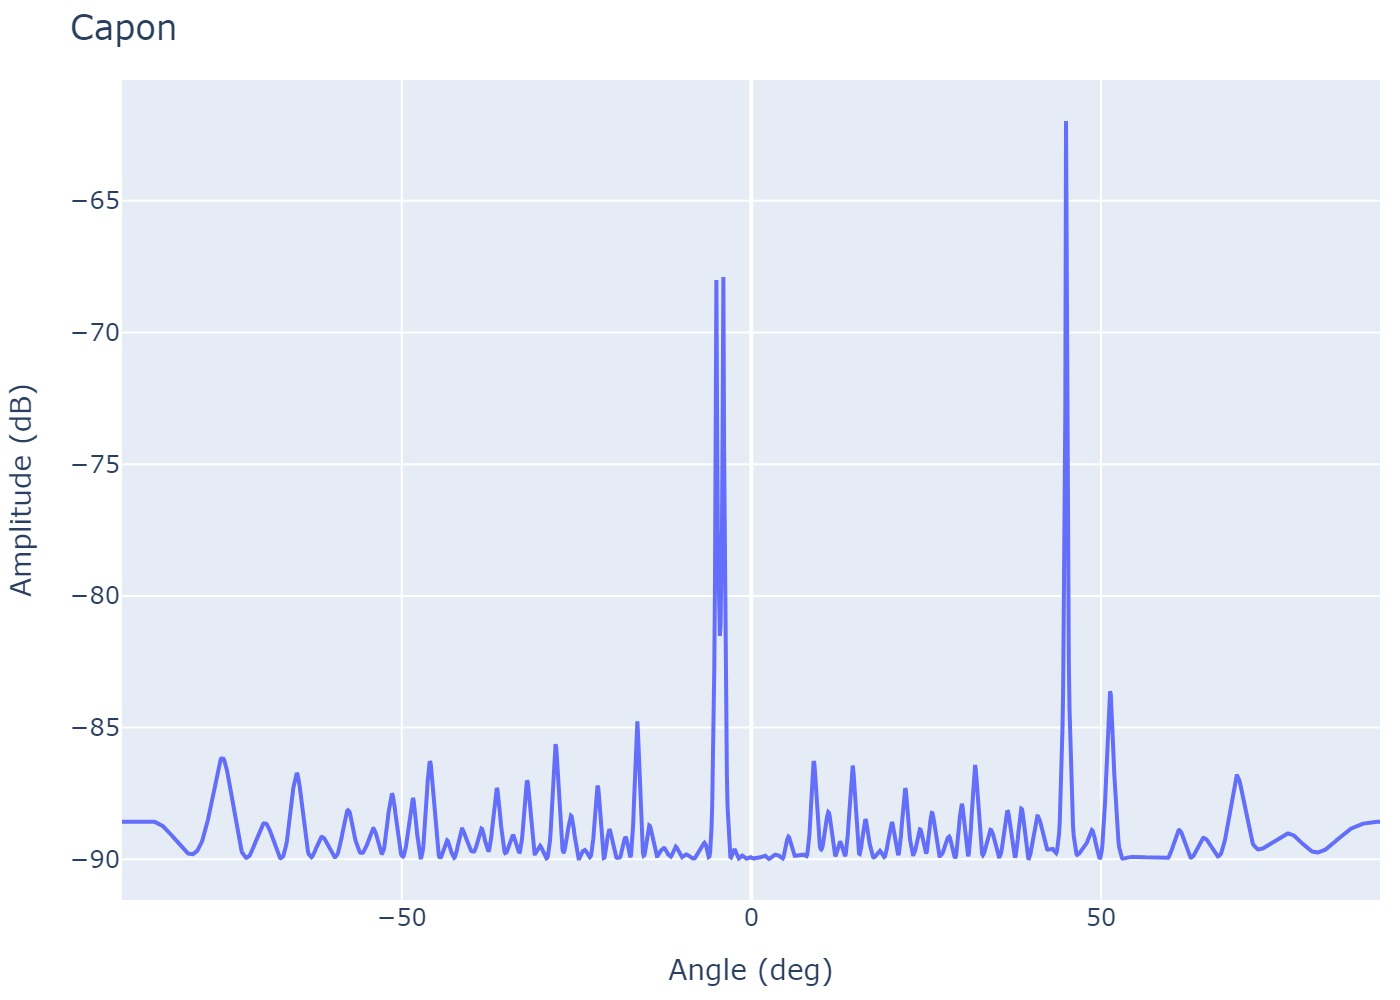

In [18]:
# Create figure for Capon results
fig = go.Figure()

# Plot Capon pseudo-spectrum
fig.add_trace(go.Scatter(x=scan_angle, y=ps_capon, name="Pseudo Spectrum"))

# Configure plot layout
fig.update_layout(
    title="Capon",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Bartlett Beamformer

The Bartlett beamformer (also called conventional beamforming) is the classical approach to DoA estimation:

**Principle:**

- Delay-and-sum beamforming in spatial domain
- Equivalent to Fourier-based spatial processing
- Maximum likelihood estimator under certain conditions

**Characteristics:**

- Simple implementation with low computational cost
- Provides baseline performance reference
- Limited resolution compared to adaptive methods
- Useful for initial target detection and comparison


In [19]:
# Import Bartlett beamformer
from radarsimpy.processing import doa_bartlett

# Apply Bartlett (conventional) beamformer
# Classical delay-and-sum beamforming approach
ps_bartlett = doa_bartlett(covmat, scanangles=scan_angle)

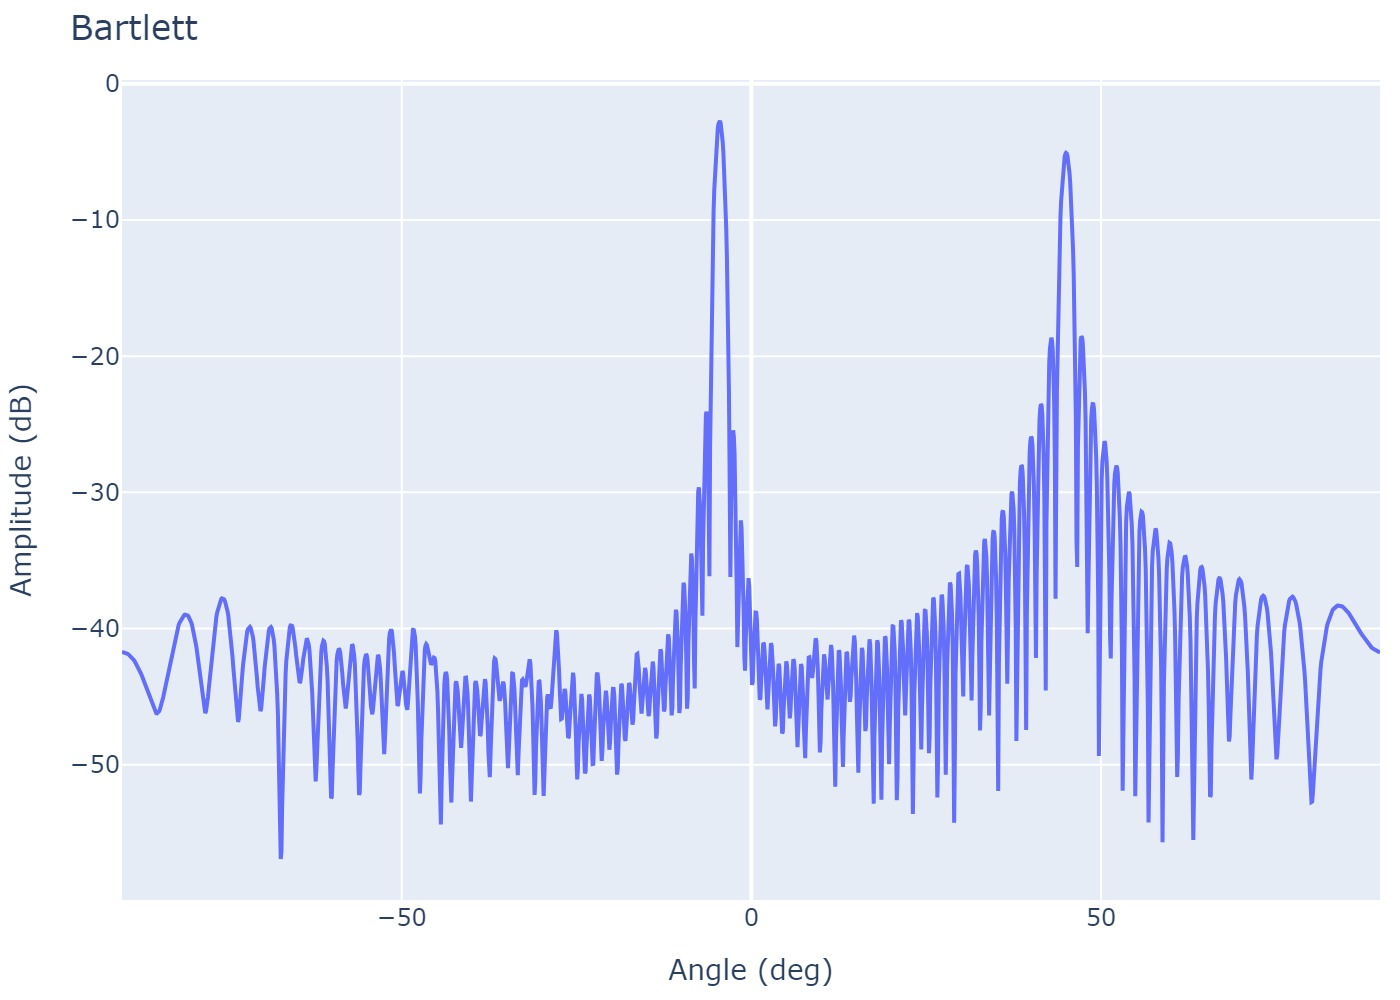

In [20]:
# Create figure for Bartlett results
fig = go.Figure()

# Plot Bartlett pseudo-spectrum
fig.add_trace(go.Scatter(x=scan_angle, y=ps_bartlett, name="Pseudo Spectrum"))

# Configure plot layout
fig.update_layout(
    title="Bartlett",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Angle (deg)"),
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to implement and compare various Direction of Arrival (DoA) estimation algorithms using RadarSimPy:

### Key Takeaways

**1. MIMO Radar Configuration**

- Configured a 2×64 MIMO array creating a 128-element virtual aperture
- Understood the relationship between transmitter/receiver placement and virtual array synthesis
- Set up FMCW radar parameters for millimeter-wave operation at 60.5 GHz

**2. Signal Processing Pipeline**

- Simulated realistic radar returns with noise using `sim_radar`
- Applied 2D range-Doppler FFT with appropriate windowing
- Extracted spatial snapshots and computed covariance matrices for DoA algorithms

**3. Algorithm Comparison**
The challenging scenario with three targets (two separated by only 1°) demonstrated:

- **FFT-based methods**: Limited by array aperture, unable to resolve closely-spaced targets
- **MUSIC & Root-MUSIC**: High-resolution subspace methods successfully resolving all three targets
- **ESPRIT**: Efficient closed-form solution with comparable performance to MUSIC
- **IAA**: Iterative approach with excellent side-lobe suppression
- **Capon (MVDR)**: Adaptive beamformer with better resolution than classical methods
- **Bartlett**: Baseline conventional beamformer for reference

**4. Practical Insights**

- Subspace methods (MUSIC, ESPRIT) require knowing the number of sources
- Root-MUSIC offers computational efficiency without spectral scanning
- IAA provides robust performance without source number estimation
- Trade-offs exist between resolution, computational complexity, and robustness

**5. RadarSimPy Capabilities**

- Complete radar system modeling with realistic parameters
- Comprehensive DoA algorithm library in the `processing` module
- Easy-to-use API for comparing different estimation techniques
- End-to-end simulation from system configuration to DoA estimation

### Experiment Further

Try modifying the parameters to explore different scenarios:

1. **Array configuration variations**:

   - Change the number of transmitters and receivers
   - Test different element spacings (λ/4, λ, 2λ)
   - Explore non-uniform array geometries

2. **Target scenarios**:

   - Vary target separations (0.5°, 2°, 5°)
   - Test different SNR levels by adjusting RCS values
   - Add more targets to test algorithm limits

3. **Algorithm parameters**:

   - Vary the number of snapshots for covariance estimation
   - Compare performance with different scan resolutions
   - Test robustness with incorrect source number estimates

4. **Signal processing**:

   - Experiment with different window functions
   - Adjust sidelobe suppression levels
   - Compare coherent vs. non-coherent integration

5. **2D DoA estimation**:
   - Extend to planar arrays for azimuth and elevation
   - Implement joint angle estimation
   - Test cross-elevation ambiguities

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Processing Module: https://radarsimx.github.io/radarsimpy/processing.html
- MIMO Radar Theory: Virtual array synthesis and spatial multiplexing
- DoA Estimation: MUSIC, ESPRIT, and adaptive beamforming algorithms
- Array Signal Processing: Spatial spectrum estimation techniques
